### Exponential Regression

We want to model the number of bacteria grown in a set time interval with two distinct features. These are described below.
$$
x_{\textrm{temprature}} \in \mathbb{R}
$$
$$
x_{\textrm{humidity}} =
    \begin{cases}
      1 & \text{if humidity $> 80\%$}\\
      0 & \text{if humidity $\leq 80\%$}
    \end{cases}  
$$
Firstly, we examine the data to find a suitable model.

In [96]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

# Plotting configuration
%config InlineBackend.figure_format = 'retina'
plt.style.use(['science', 'notebook', 'grid'])

In [100]:
df = pd.read_csv('data/exponential_regression.csv')
[bacteria, temperature, humidity] = df[['bacteria_grown', 'temperature', 'humidity']]
df.head()

,bacteria_grown,temperature,humidity
0,80750.679832,24.817575,1
1,33842.079471,23.825936,0
2,194891.669321,23.268858,1
3,15359.851544,21.030399,1
4,64627.861059,23.704124,0


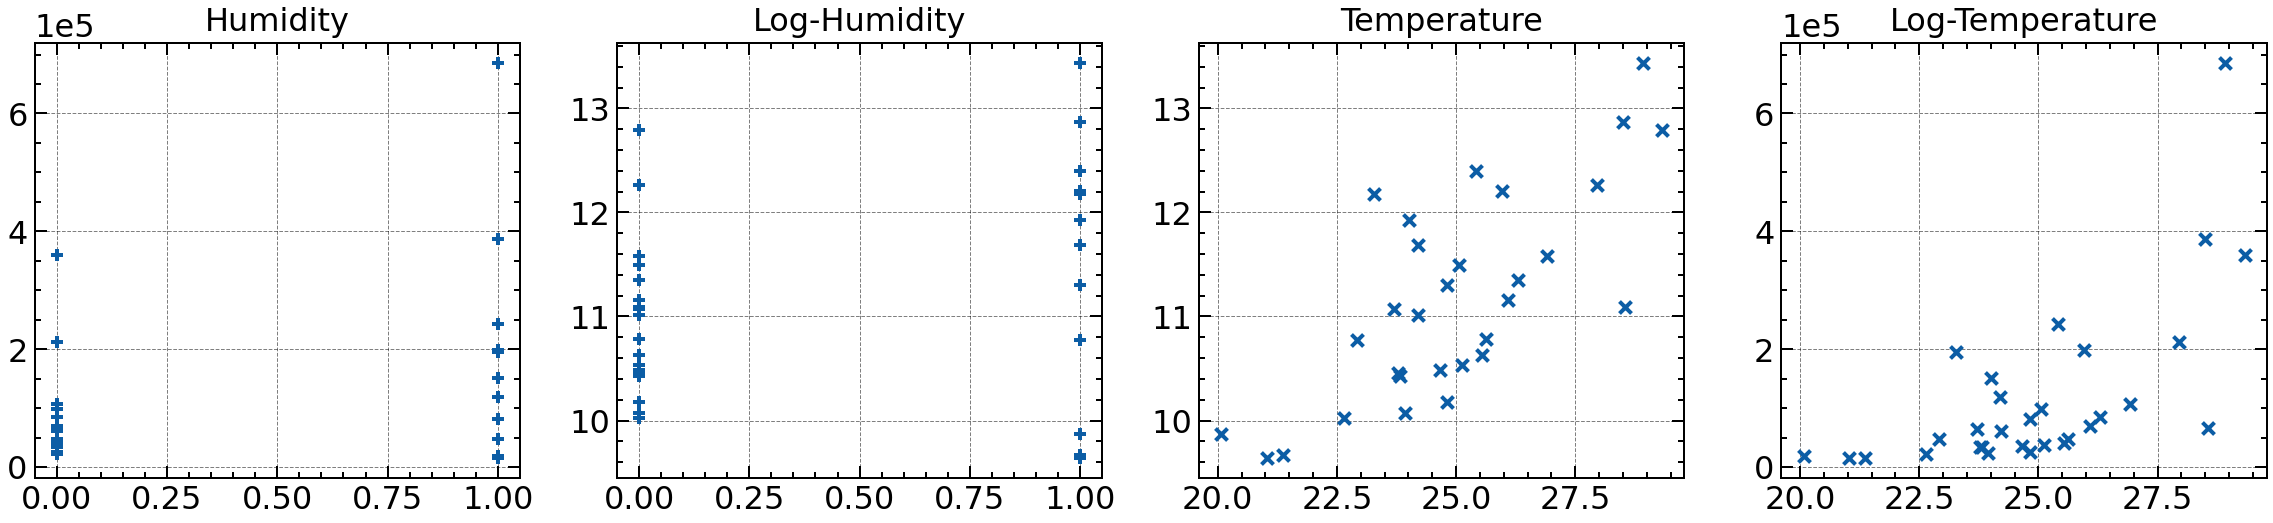

In [101]:
fig, axs = plt.subplots(1, 4)

axs[0].scatter(df['humidity'], df['bacteria_grown'], marker='+')
axs[0].set_title('Humidity')
axs[0].ticklabel_format(axis='y', style='sci', scilimits=(5, 5))

axs[1].scatter(df['humidity'], np.log(df['bacteria_grown']), marker='+')
axs[1].set_title('Log-Humidity')

axs[2].scatter(df['temperature'], np.log(df['bacteria_grown']), marker='x')
axs[2].set_title('Temperature')

axs[3].scatter(df['temperature'], df['bacteria_grown'], marker='x')
axs[3].set_title('Log-Temperature')
axs[3].ticklabel_format(axis='y', style='sci', scilimits=(5, 5))

fig.set_size_inches(20, 4)
plt.show()

### Model Selection

Since the data is exponential with respect to the features. We can simply modify the problem statement by examining the log-transformed data instead. This way we can utilize linear regression models to find an exponential curve that best fits the data. This is acceptable since the transformation $f(z) = e^z$ is a bijection. Therefore our regression model becomes:

$$
Y_i = \exp\big\{\beta_0 + \beta_1 x_{\text{temp}} + \beta_2 x_{\text{humidity}} + \varepsilon_i \big\} \iff Z_i \triangleq \ln Y_i = \beta_0 + \beta_1 x_{\text{temp}} + \beta_2 x_{\text{humidity}} + \varepsilon_i
$$

In the coming section we solve to normal equations to obtain the OLS estimate of $\hat{\mathbf{\beta}}$ and plot the resulting regression line and print its $R^2$ and $R_{\text{adj}}^2$ values.

Recall, the normal equations:
$$
\hat{\mathbf{\beta}} =\mathbf{X}^{\dagger}\mathbf{Z} = (\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}\mathbf{Z}
$$

And the definition of the explanatory power:

$$
R^2 = 1 - \frac{\text{SSE}}{\text{SST}}
$$

$$
R_{\text{adj}}^2 = 1 - \frac{\text{SSE} / (n-k-1)}{\text{SST} / (n - 1)} 
$$

In which:

$$
\text{SST} = \sum_{i=1}^n(z_i - \bar{z})^2
$$
$$
\text{SSE} = \sum_{i=1}^n(z_i - \hat{z}_i)^2
$$

In [102]:
# Creating design matrix.
n_observations = len(df)
x0 = np.ones(n_observations)
x1 = np.array(df['temperature'])
x2 = np.array(df['humidity'])

X = np.stack([x0, x1, x2]).T
Z = np.array(np.log(df['bacteria_grown']))

# Solving normal equations.
beta_ols = np.linalg.inv(X.T @ X) @ X.T @ Z
H_hat = X @ np.linalg.inv(X.T @ X) @ X.T 

# R2 and Adjusted R2 values.
Z_sst = Z - np.mean(Z)
Z_sse = Z - H_hat @ Z
sst = Z_sst.T @ Z_sst
sse = Z_sse.T @ Z_sse

n_features = 2

r2 = 1 - sse/sst
r2_adj = 1 - (sse/(n_observations - n_features - 1))/(sst/(n_observations - 1))

print('OLS beta coefficients: ', beta_ols)
print('R squared: ', r2)
print('Adjusted R squared: ', r2_adj)

OLS beta coefficients:  [1.17201041 0.38493266 1.00574571]
R squared:  0.7812378089302527
Adjusted R squared:  0.7650332021843456


Given the model above, we can now plot the regression line in the bacteria-temperature plane. Both for the log-transformed values and for the non-transformed values.

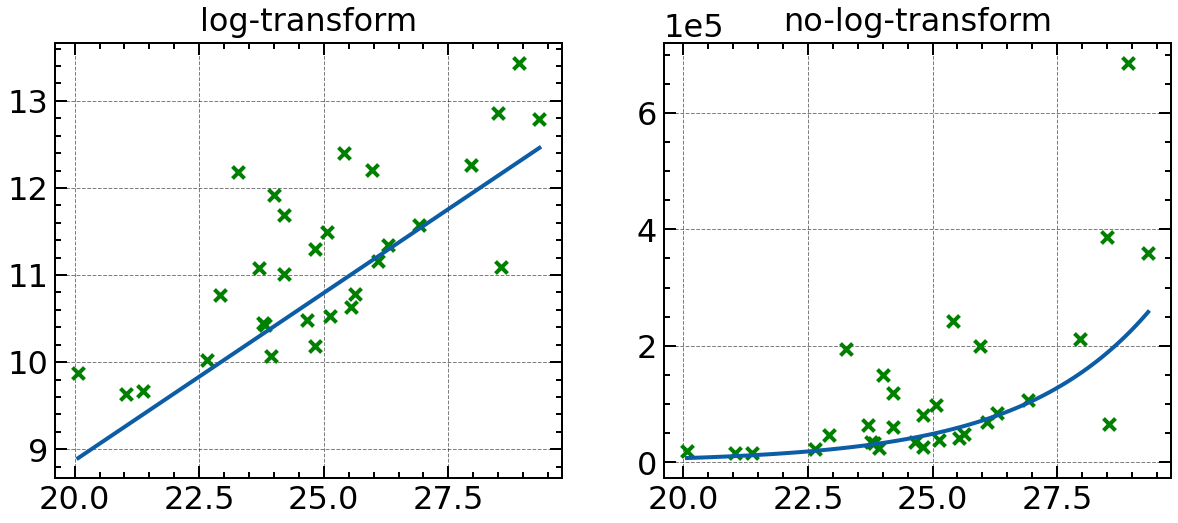

In [103]:
fig, axs = plt.subplots(1, 2)
x = df['temperature']
x = np.linspace(np.min(x), np.max(x), 100)
z = beta_ols[0] + beta_ols[1] * x
y = np.exp(z)

axs[0].set_title('log-transform')
axs[0].scatter(df['temperature'], np.log(df['bacteria_grown']), marker='x', color='green')
axs[0].plot(x, z)

axs[1].set_title('no-log-transform')
axs[1].scatter(df['temperature'], df['bacteria_grown'], marker='x', color='green')
axs[1].plot(x, y)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(5, 5))

fig.set_size_inches(10, 4)
plt.show()

### Residual Analysis

For linear regression to work, we need to check the assumptions of the model after it has been fitted to the data. The three assumptions that need to be check is that:

* The residuals have constant variance 
* The residuals are independent from the features
* The residuals are normally distributed

Residuals can be calculated as:
$$
\mathbf{e} = \mathbf{Z} - \hat{\mathbf{Z}} = (\mathbf{I} - \mathbf{H})\mathbf{Z}, \quad \mathbf{H} = \mathbf{X}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{X}^{\text{T}}
$$

This is done below.

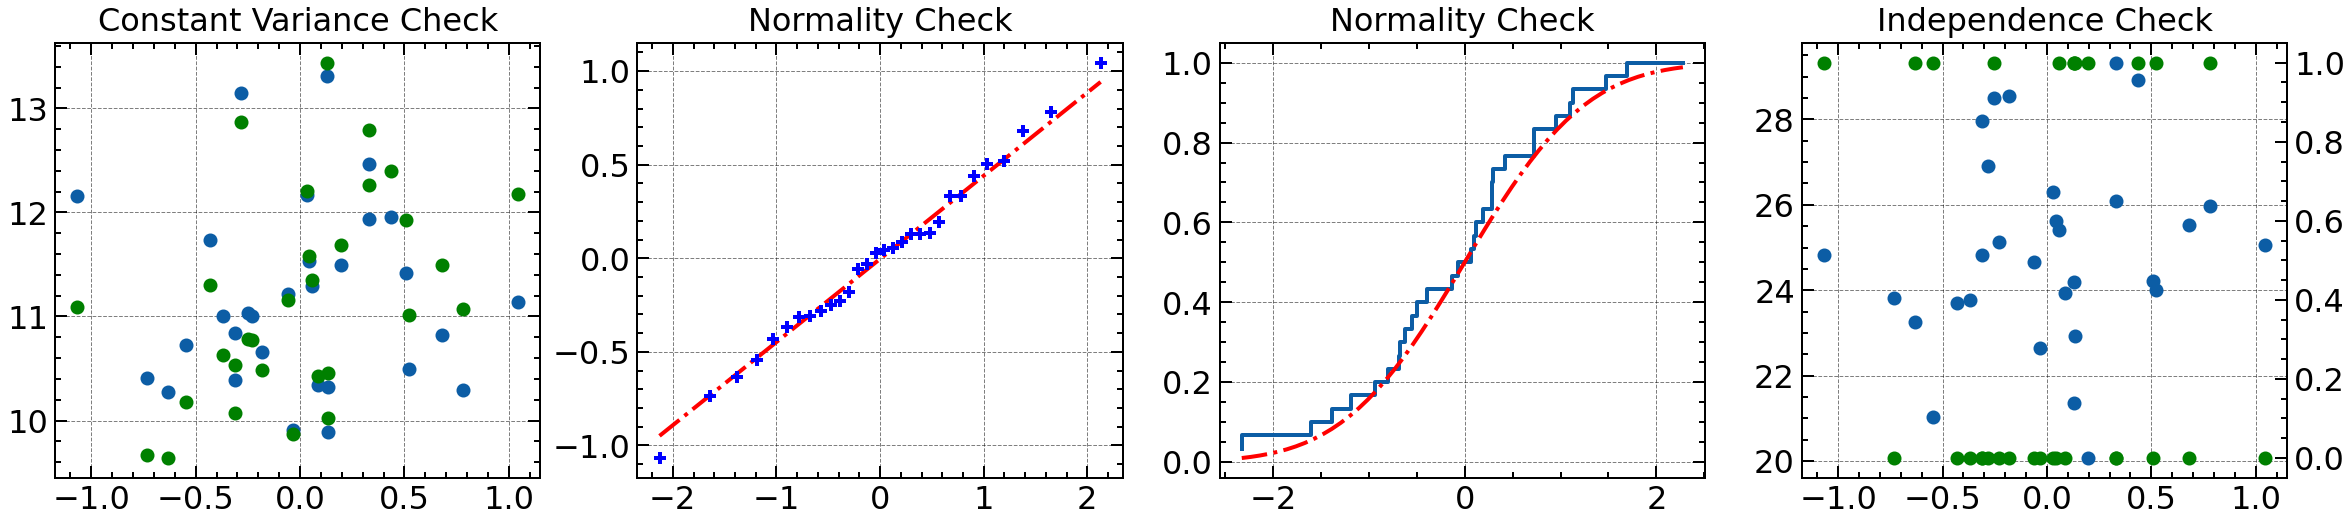

In [104]:
# Calculating residuals and predicted values.
residuals = Z_sse
z_hat = H_hat @ Z

# Check constant variance across observations/predicted values
fig, axs = plt.subplots(1, 4)
axs[0].scatter(residuals, z_hat)
axs[0].scatter(residuals, np.log(df['bacteria_grown']), color='green')
axs[0].set_title('Constant Variance Check')

# Check normality with qq plot
from utils.qq_plot import qq_plot_normal
qq_plot_normal(residuals, 'Normality Check', axs[1])

# Check normaility with ecdf plot
from utils.ecdf_plot import ecdf_normal
ecdf_normal(residuals, 'Normality Check', axs[2])

# Check independence of features
axs[3].scatter(residuals, df['temperature'])
ax3 = axs[3].twinx()
ax3.scatter(residuals, df['humidity'], color='green')
ax3.grid(False)
axs[3].set_title('Independence Check')

fig.set_size_inches(20, 4)
plt.show()

### Confidence and Prediction Intervals

With a valid linear model we can begin using statstical inference. One application is to make confidence intervals for the mean $\mu_Z = \mathbb{E}[Z]$ and $\mu_Y = \mathbb{E}[Y]$. Also, it is possible to make predictions for new observations beyond the training data. One can construct intervals for these predictions, called prediction intervals.


For the transformed model we can estimate its mean as the following:

$$
\hat{\mu}_Z = {\mathbf{x}}^{\text{T}} \hat{\mathbf{\beta}} \sim \text{N}({\mathbf{x}}^{\text{T}}{\mathbf{\beta}},~\sigma^2 \mathbf{x}^{\text{T}}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{x})
$$

Which can be drived from the fact that $\hat{\mathbf{\beta}} \sim \text{N}(\mathbf{\beta},~\sigma^2 (\mathbf{X}^{\text{T}}\mathbf{X}))$. From the aforementioned distribution we can derive a confidence interval for the true mean $\mu_Z = \mathbf{x}^{\text{T}}\mathbf{\beta}$. Then we obtain the following confidence interval with significance level $\alpha$:

$$
I_{\mu_Z}^{1-\alpha} = \mathbf{x}^{\text{T}}\hat{\mathbf{\beta}} \mp t_{\frac{\alpha}{2}}(n-k-1)s\sqrt{\mathbf{x}^{\text{T}}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{x}}
$$

And so the transformed confidence interval becomes:

$$
I_{\mu_Y}^{1-\alpha} = \exp\big\{\mathbf{x}^{\text{T}}\hat{\mathbf{\beta}} \mp t_{\frac{\alpha}{2}}(n-k-1)s\sqrt{\mathbf{x}^{\text{T}}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{x}}\big\}
$$

In which $s^2 = \frac{\text{SSE}}{n-k-1}$.

This interval has a $1-\alpha$ % chance of containing the true mean. This is, however, different from asking for an interval for a new observation. To construct an interval for new observations we must have the distribution of $Z$ and $Y$ respectively. For the transformed problem we simply obtain the distribution of $Z$ by noting it is a sum of normal random variables. Thus we arrive at:

$$
Z \sim \text{N}(\mu,~\sigma^2)~~ \text{and} ~~\hat{\mu}_Z \sim \text{N}(\mu,~ \sigma^2\mathbf{x}^{\text{T}}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{x})
$$

If we create the difference $Z - \hat{\mu}_Z$ and find its distribution, we can derive the following interval for $Z$ itself.

$$
I_{Z}^{1-\alpha} = \mathbf{x}^{\text{T}}\hat{\mathbf{\beta}} \mp t_{\frac{\alpha}{2}}(n-k-1)s\sqrt{1+\mathbf{x}^{\text{T}}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{x}}
$$

And so the transformed confidence interval becomes:
$$
I_{Y}^{1-\alpha} = \exp\big\{\mathbf{x}^{\text{T}}\hat{\mathbf{\beta}} \mp t_{\frac{\alpha}{2}}(n-k-1)s\sqrt{1+\mathbf{x}^{\text{T}}(\mathbf{X}^{\text{T}}\mathbf{X})^{-1}\mathbf{x}}\big\}
$$


### Confidence and Prediction Bands

Confidence and prediction intervals can be applied for every possible value of the $\mathbf{x}$ vector. Doing this we can obtain so-called confidence and interval bands. These are demonstrated for $x_2 = 0$ below. 

In [105]:
from scipy.stats import t

# Estimating sigma.
sigma_hat = (Z_sse.T @ Z_sse) / (n_observations - n_features - 1)

# Creating the upper and lower CI bounds (pre-defined to 95 % confidence).
def CI_bounds(obs: np.array, beta: np.array, X: np.array, sigma: float) -> list:
    lower_bound = obs.T @ beta - t.ppf(0.025, n_observations - n_features - 1) * sigma * np.sqrt(obs.T @ np.linalg.inv(X.T @ X) @ obs)
    upper_bound = obs.T @ beta + t.ppf(0.025, n_observations - n_features - 1) * sigma * np.sqrt(obs.T @ np.linalg.inv(X.T @ X) @ obs)
    return lower_bound, upper_bound

# Creating the upper and lower PI bounds (pre-defined to 95 % confidence).
def PI_bounds(obs: np.array, beta: np.array, X: np.array, sigma: float) -> list:
    lower_bound = obs.T @ beta - t.ppf(0.025, n_observations - n_features - 1) * sigma * np.sqrt(1 + obs.T @ np.linalg.inv(X.T @ X) @ obs)
    upper_bound = obs.T @ beta + t.ppf(0.025, n_observations - n_features - 1) * sigma * np.sqrt(1 + obs.T @ np.linalg.inv(X.T @ X) @ obs)
    return lower_bound, upper_bound

# Creating CI and PI bands.
x = np.linspace(np.min(df['temperature']), np.max(df['temperature']), 100)
conf_band = []
pred_band = []
for observation in x:
    obs = np.array([1, observation, 0])
    conf_band.append(CI_bounds(obs, beta_ols, X, sigma_hat))
    pred_band.append(PI_bounds(obs, beta_ols, X, sigma_hat))

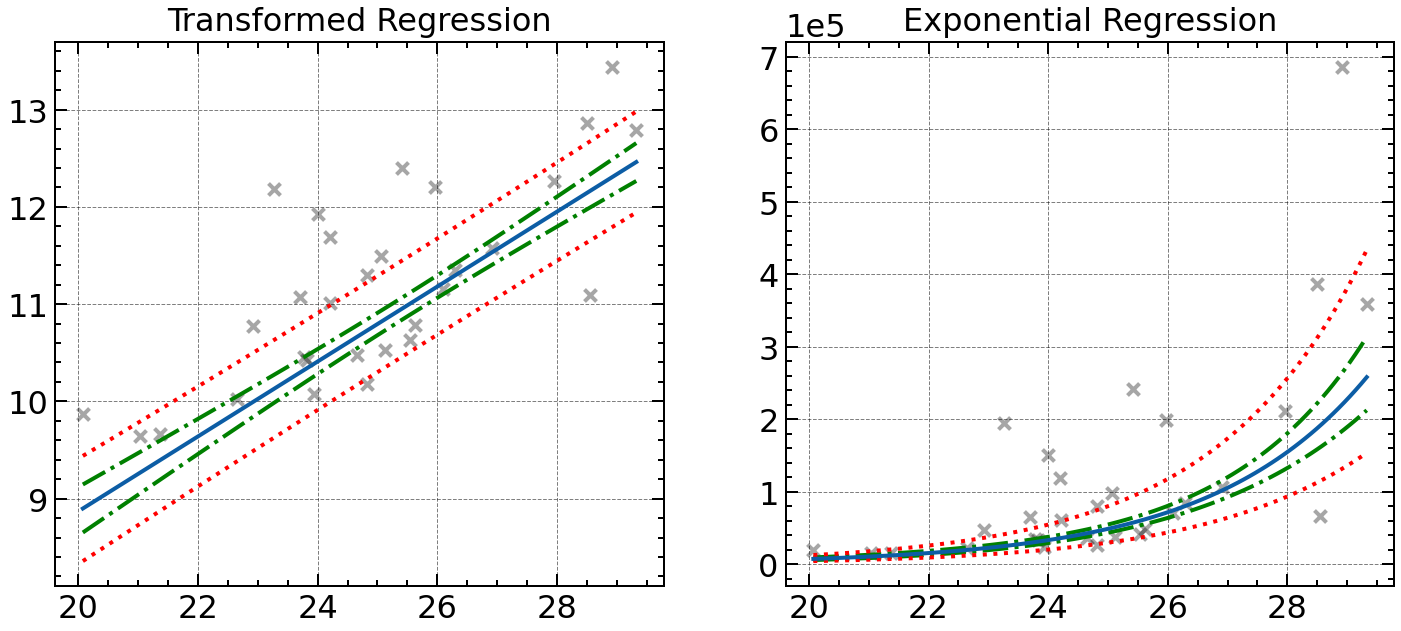

In [108]:
# Plotting confidence bands and prediction bands.
fig, axs = plt.subplots(1, 2)

axs[0].plot(x, conf_band, color='green', linestyle='dashdot')
axs[0].plot(x, pred_band, color='red', linestyle='dotted')
axs[0].plot(x, z)
axs[0].scatter(df['temperature'], np.log(df['bacteria_grown']), marker='x', alpha=0.35, color='black')
axs[0].set_title('Transformed Regression')

axs[1].plot(x, np.exp(conf_band), color='green', linestyle='dashdot')
axs[1].plot(x, np.exp(pred_band), color='red', linestyle='dotted')
axs[1].plot(x, y)
axs[1].scatter(df['temperature'], df['bacteria_grown'], marker='x', alpha=0.35, color='black')
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(5, 5))
axs[1].set_title('Exponential Regression')

fig.set_size_inches(12, 5)
plt.show()